In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os

In [2]:
ini_wd = os.getcwd()
os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters, pack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
from clusterization.all_methods import cluster_data_1d, cluster_data
from local_models import calc_cond_var_fuzzy
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
logs_folder = config['files_folders']['logs']

In [6]:
logging.basicConfig(level=logging.DEBUG,
                    filename=f'{logs_folder}/seasonal_testing.log',
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

In [7]:
pd.options.display.max_colwidth = 500

# Reading files

In [8]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [9]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


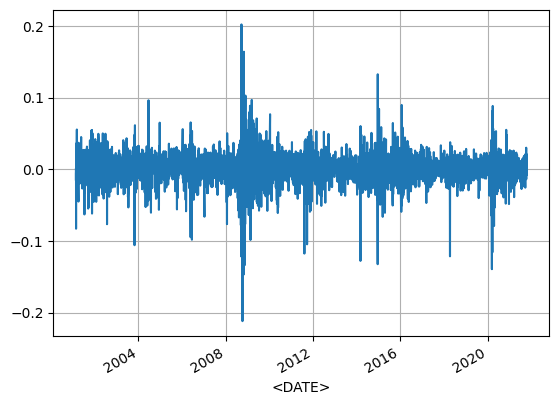

In [10]:
rtsi['log return'].plot()

plt.grid()
plt.show()

In [11]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

In [12]:
rtsi['day of week'] = rtsi.index.dayofweek + 1

In [13]:
rtsi['day of week']

<DATE>
2001-02-18    7
2001-02-19    1
2001-02-20    2
2001-02-21    3
2001-02-22    4
             ..
2021-10-11    1
2021-10-12    2
2021-10-13    3
2021-10-14    4
2021-10-15    5
Name: day of week, Length: 5174, dtype: int64

In [14]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(rtsi['day of week'].values,
                                    a=[0, 2],
                                    b=[2, 4],
                                    c=[2, 4],
                                    d=[4, 6])

array([0., 0.])

# Setting data & parameters

In [15]:
rescale_factor = 1

In [16]:
start_date = '2010-01-01'

In [17]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

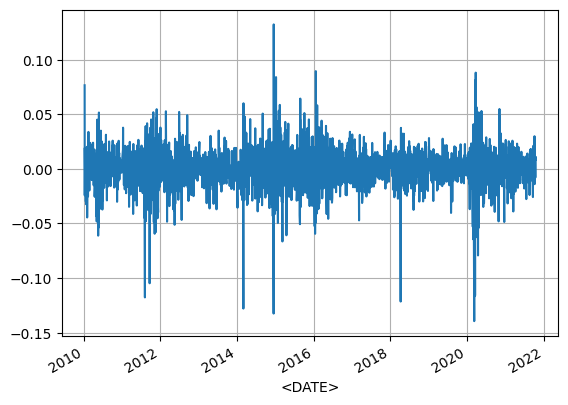

In [18]:
input_data.plot()

plt.grid()
plt.show()

In [19]:
input_data.describe()

count    2965.000000
mean        0.000091
std         0.017722
min        -0.139486
25%        -0.008678
50%         0.000601
75%         0.009209
max         0.132462
Name: log return, dtype: float64

In [20]:
n = input_data.shape[0]

In [21]:
n

2965

In [22]:
input_data.index.dayofweek + 1

Int64Index([1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
            ...
            1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
           dtype='int64', name='<DATE>', length=2965)

## Train / test split

In [23]:
n_train = 100  # 2000

n_test = 10
n_test = min(n - n_train, n_test)

In [24]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

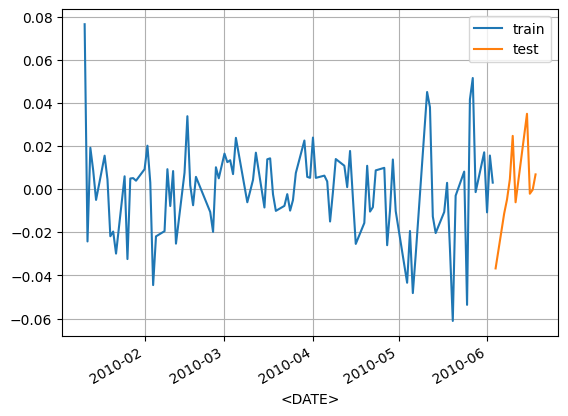

In [25]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [26]:
train.describe()

count    100.000000
mean      -0.000333
std        0.021419
min       -0.061136
25%       -0.010510
50%        0.003145
75%        0.010414
max        0.076686
Name: log return, dtype: float64

## Antecedent parameters

In [27]:
# set #1
clusterization_method_1 = 'trapezoidal'

n_clusters_1 = 2

a = [1, 1]
b = [1, 5]
c = [1, 5]
d = [5, 5]

# set #2
clusterization_method_2 = 'gaussian'

n_clusters_2 = 2

# variances = [7, 6, 3, 5]
# centers = [-7.5, -1.5, 1.5, 4]
variances = [7, 5]
centers = [-4.5, 2.5]

In [28]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(2,
                                    a=a,
                                    b=b,
                                    c=c,
                                    d=d)

array([0.75, 0.25])

In [29]:
clusterization_parameters = [{'a': a, 'b': b, 'c': c, 'd': d, 'n_clusters': n_clusters_1},
                             {'centers': centers, 'variances': variances, 'n_clusters': n_clusters_2}]
clusterization_methods = [clusterization_method_1, clusterization_method_2]
n_clusters = n_clusters_1 * n_clusters_2

## Consequent parameters

In [63]:
# technical parameters for arch_model function
garch_mean = 'Zero'
garch_dist = 'normal'

# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
# first_h = [train[0] ** 2]  # TODO: TRY THIS
first_h = np.array(first_h)

# parameters constraints
lower_bounds = [0] * (1 + p + q) * n_clusters
upper_bounds = [+1000] * n_clusters + [1] * (p + q) * n_clusters
bounds = (lower_bounds, upper_bounds)

### Using classic GARCH to get initial parameters values

In [64]:
garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -172.81375246629065
Iteration:      2,   Func. Count:     14,   Neg. LLF: -231.83780274495433
Iteration:      3,   Func. Count:     21,   Neg. LLF: -246.87441129590061
Iteration:      4,   Func. Count:     28,   Neg. LLF: -246.6371189750122
Iteration:      5,   Func. Count:     33,   Neg. LLF: -250.4869892567008
Iteration:      6,   Func. Count:     37,   Neg. LLF: -250.4870954083915
Iteration:      7,   Func. Count:     41,   Neg. LLF: -250.4871000056945
Iteration:      8,   Func. Count:     44,   Neg. LLF: -250.4871000055288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -250.4871000056945
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


/Applications/anaconda3/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004542. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [65]:
garch_fitted.params

omega       0.000018
alpha[1]    0.116398
beta[1]     0.836906
Name: params, dtype: float64

In [66]:
alpha_0_ini = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters)])
alpha_ini = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters)])
beta_ini = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters)])

In [67]:
# alpha_0_ini, alpha_ini, beta_ini = unpack_1d_parameters(garch_fitted.params.values, p=p, q=q, n_clusters=n_clusters)

In [68]:
parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [69]:
parameters_ini

{'alpha_0': array([1.76128451e-05, 1.76128451e-05, 1.76128451e-05, 1.76128451e-05]),
 'alpha': array([[0.11639833],
        [0.11639833],
        [0.11639833],
        [0.11639833]]),
 'beta': array([[0.8369058],
        [0.8369058],
        [0.8369058],
        [0.8369058]])}

In [70]:
# # initial parameters values for LS to start with
# alpha_0_ini = np.array([garch_fitted.params.loc['omega']] * n_clusters)
# alpha_ini = np.array([[1] * n_clusters] * q)
# beta_ini = np.array([[1] * n_clusters] * p)
# parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [71]:
list(alpha_ini.flatten())

[0.11639832899030729,
 0.11639832899030729,
 0.11639832899030729,
 0.11639832899030729]

### Setting dict w/ all consequent parameters

In [72]:
local_method_parameters = {'p': p, 'q': q, 'mean': garch_mean, 'dist': garch_dist, 'first_h': first_h,
                           'bounds': bounds, 'parameters_ini': parameters_ini}

## Other params

In [73]:
n_last_points_to_use_for_clustering_1 = 1
n_last_points_to_use_for_clustering_2 = 5
n_last_points_to_use_for_clustering = [n_last_points_to_use_for_clustering_1, n_last_points_to_use_for_clustering_2]

In [74]:
data_to_cluster_1 = pd.Series(train.index.dayofweek + 1, index=train.index).copy()
data_to_cluster_2 = 'train'
data_to_cluster = [data_to_cluster_1, data_to_cluster_2]

In [155]:
cluster_sets_conjunction = 'prod'

normalize = True

n_points_fitting = 10

optimization = 'ls'
optimization_parameters = {'ftol': 1e-10,
                           'gtol': 1e-10,
                           'method': 'dogbox'}

# Testing `FuzzyVolatilityModel` class

In [156]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                           data_to_cluster=data_to_cluster,
                           cluster_sets_conjunction=cluster_sets_conjunction,
                           normalize=normalize,
                           n_points_fitting=n_points_fitting,
                           optimization=optimization,
                           optimization_parameters=optimization_parameters)

## `fit`

In [157]:
%%time

fvm.cluster()

CPU times: user 11.8 ms, sys: 3.51 ms, total: 15.3 ms
Wall time: 17.1 ms


In [158]:
fvm._fitting_slice

slice(-10, None, None)

In [159]:
%%time

fvm.fit()

CPU times: user 21 s, sys: 838 ms, total: 21.8 s
Wall time: 22.5 s


In [160]:
fvm.bounds

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1000, 1000, 1000, 1000, 1, 1, 1, 1, 1, 1, 1, 1])

In [161]:
np.array(fvm.bounds).T

array([[   0, 1000],
       [   0, 1000],
       [   0, 1000],
       [   0, 1000],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1],
       [   0,    1]])

In [162]:
fvm._fitting_slice

slice(-10, None, None)

In [163]:
n_last_points_to_use_for_clustering

[1, 5]

In [164]:
fvm.alpha_0

array([0.00033572, 0.00033529, 0.00033553, 0.00033529])

In [165]:
fvm.alpha

array([[0.13919538, 0.13919535, 0.13919536, 0.13919535]])

In [166]:
fvm.beta

array([[0.00083769, 0.00083769, 0.00083769, 0.00083769]])

In [167]:
garch_fitted.params

omega       0.000018
alpha[1]    0.116398
beta[1]     0.836906
Name: params, dtype: float64

In [168]:
fvm._parameters_hist

[{'alpha_0': array([0.00033572, 0.00033529, 0.00033553, 0.00033529]),
  'alpha': array([[0.13919538, 0.13919535, 0.13919536, 0.13919535]]),
  'beta': array([[0.00083769, 0.00083769, 0.00083769, 0.00083769]])}]

In [169]:
fvm.membership_degrees_current

array([0.00171404, 0.24828596, 0.00514212, 0.74485788], dtype=float128)

In [170]:
fvm.clusters_parameters_current

{'n_clusters': 4,
 'params by sets': [{'a': [1, 1],
   'b': [1, 5],
   'c': [1, 5],
   'd': [5, 5],
   'n_clusters': 2},
  {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}]}

In [171]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [172]:
fvm._membership_degrees_hist

[array([0.00171404, 0.24828596, 0.00514212, 0.74485788], dtype=float128)]

In [173]:
fvm.train_data

<DATE>
2010-01-11    0.076686
2010-01-12   -0.024211
2010-01-13    0.019327
2010-01-14    0.008749
2010-01-15   -0.004911
                ...   
2010-05-28   -0.001298
2010-05-31    0.017188
2010-06-01   -0.010699
2010-06-02    0.015701
2010-06-03    0.003104
Name: log return, Length: 100, dtype: float64

## `forecast`

In [174]:
fvm.forecast()

In [175]:
fvm.current_output

0.00033694600875488456954

In [176]:
fvm._hist_output

[0.00033694600875488456954]

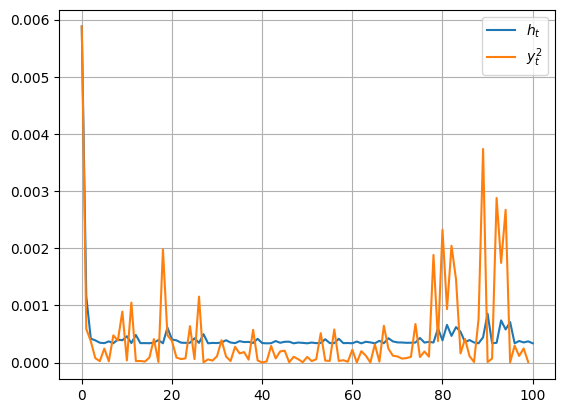

In [177]:
plt.plot(fvm.h, label='$h_t$')
plt.plot(train.values ** 2, label='$y_t^2$')

plt.legend()
plt.grid()
plt.show()

## `feed_daily_data`

In [178]:
n_test_small = 10
test_small = test.iloc[:n_test_small].copy()
input_cut = pd.concat([train, test_small]).copy()

data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
data_to_cluster_test_2 = 'train'
data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]
# data_to_cluster = test_small.index.dayofweek + 1
# data_to_cluster = pd.Series(data_to_cluster, index=test_small.index)

In [179]:
data_to_cluster_test

[<DATE>
 2010-06-04    5
 2010-06-07    1
 2010-06-08    2
 2010-06-09    3
 2010-06-10    4
 2010-06-11    5
 2010-06-15    2
 2010-06-16    3
 2010-06-17    4
 2010-06-18    5
 Name: <DATE>, dtype: int64,
 'train']

In [180]:
fvm._membership_degrees_hist

[array([0.00171404, 0.24828596, 0.00514212, 0.74485788], dtype=float128)]

In [181]:
%%time

fvm.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test)

CPU times: user 28.1 s, sys: 830 ms, total: 28.9 s
Wall time: 29.1 s


In [182]:
fvm.data_to_cluster

,<DATE>,log return
<DATE>,,
2010-01-11,1.0,0.076686
2010-01-12,2.0,-0.024211
2010-01-13,3.0,0.019327
2010-01-14,4.0,0.008749
2010-01-15,5.0,-0.004911
...,...,...
2010-06-11,5.0,-0.006017
2010-06-15,2.0,0.035086
2010-06-16,3.0,-0.002051


In [183]:
fvm.h

array([0.00135009, 0.00023672, 0.00023523, 0.00023523, 0.00023523,
       0.00023523, 0.00023523, 0.00023523, 0.00023523, 0.00023523,
       0.00023523], dtype=float128)

In [184]:
fvm.membership_degrees_hist

,0,1,2,3
<DATE>,,,,
2010-06-04,0.000000,0.000000,0.007138,0.992862
2010-06-07,0.007372,0.992628,0.000000,0.000000
2010-06-08,0.005492,0.744508,0.001831,0.248169
2010-06-09,0.003707,0.496293,0.003707,0.496293
2010-06-10,0.001808,0.248192,0.005425,0.744575
2010-06-11,0.000000,0.000000,0.006985,0.993015
2010-06-15,0.004971,0.745029,0.001657,0.248343
2010-06-16,0.003304,0.496696,0.003304,0.496696
2010-06-17,0.001661,0.248339,0.004983,0.745017


In [185]:
pd.DataFrame.from_records(fvm._parameters_hist, index=fvm.train_data.index[-len(fvm._parameters_hist):])

,alpha_0,alpha,beta
<DATE>,,,
2010-06-03,"[0.00033572382148525255, 0.00033529450915850863, 0.0003355256082671318, 0.00033529302479186275]","[[0.1391953795741742, 0.1391953537851246, 0.1391953626217498, 0.13919535199607172]]","[[0.00083769451868561, 0.0008376945312959551, 0.0008376945182365474, 0.0008376945626266744]]"
2010-06-04,"[0.00033572382148525255468, 0.2223313349294005108, 0.07472757573622743239, 0.00037615064560533779876]","[[0.13919536526474998468, 0.13919536766604858291, 0.38615030601509495086, 0.14164907261974665003]]","[[0.00083769451868561002617, 0.000837694531295955086, 1.3460082941971560086e-17, 1.3446664197676454283e-17]]"
2010-06-07,"[4.5587486960386425944e-07, 7.7217114254066641474e-05, 15.092000392164361289, 20.758722324812201927]","[[9.989948385993335007e-06, 9.980599196799239316e-06, 0.38615030601517436986, 0.14164907261974680797]]","[[0.6333618574915223807, 0.6333614119188304818, 1.00000000000000003643e-10, 1.00000000000000003643e-10]]"
2010-06-08,"[6.303806985698210717e-08, 4.477438682856031897e-35, 0.038749712579609784006, 6.730576128986355629e-06]","[[3.8214744697567509288e-18, 2.4865458809335852642e-05, 2.2079842978757526608e-08, 2.0237595051775313753e-05]]","[[6.9167657670897569813e-09, 0.63042824042065372244, 0.31582005805545471317, 0.6354307938014081781]]"
2010-06-09,"[1.0693644375106791187e-07, 1.7715008148734894305e-34, 0.06573418996951049648, 2.572947561162964688e-36]","[[4.362888708315687814e-11, 2.0286874408775129636e-06, 9.633186500057948928e-09, 1.6511159204439187021e-06]]","[[3.2789825373262846285e-15, 3.3044953591648754338e-10, 1.5025485933562359926e-07, 3.6005127937519369055e-10]]"
2010-06-10,"[4.730542618069352e-08, 1.0767125573659673e-09, 0.057451027990779155, 9.932856900084987e-10]","[[1.0636660846724492e-10, 1.8675720276643186e-07, 1.175280245390555e-08, 2.152802845115532e-15]]","[[9.991327346621582e-11, 2.8622628035853903e-10, 1.4986332079230172e-07, 1.557485574050938e-10]]"
2010-06-11,"[4.730542618069352e-08, 0.2446585908540565, 0.04078546549554026, 7.051504673443399e-10]","[[0.031999676829909916, 0.000995924897734609, 4.33109390380551e-10, 3.685157477074559e-12]]","[[9.999999843094285e-11, 2.8622628058913e-10, 1.1484677567455645e-07, 1.1935691506297677e-10]]"
2010-06-15,"[0.004541516690684527506, 1.3252444754370062696e-06, 0.016268481699643055546, 0.00088715049834613492256]","[[0.01593652455074818115, 3.4206239887459811547e-08, 1.4202503413919467068e-09, 6.833787063834611845e-23]]","[[0.06689524144281491841, 0.38949099478439903692, 4.295287254036169063e-08, 0.35367486885052447221]]"
2010-06-16,"[0.0045038823689798429686, 3.7707243308112245485e-05, 0.016022657902349346207, 0.0004407270141833935536]","[[0.045174329243000330675, 5.336871727191072287e-21, 4.0259001238165935805e-09, 1.5609601955879867226e-23]]","[[0.06900562248342053214, 0.22136383093700540597, 0.0003481129015537281301, 0.20559195423134091641]]"


In [186]:
ls_res = fvm.show_ls_results()
ls_res

,cost,optimality,nfev,njev,status,message,success
0,2.205836e-05,6.856437e-09,9,9,1,`gtol` termination condition is satisfied.,True
1,5.292483e-06,2.186388e-10,6,6,1,`gtol` termination condition is satisfied.,True
2,2.140279e-06,7.296020e-09,15,15,1,`gtol` termination condition is satisfied.,True
3,2.218010e-06,7.630847e-10,42,42,1,`gtol` termination condition is satisfied.,True
4,7.342397e-07,8.800586e-10,19,19,1,`gtol` termination condition is satisfied.,True
5,7.535740e-07,3.444569e-09,3,3,1,`gtol` termination condition is satisfied.,True
6,7.876368e-07,5.569922e-09,3,3,1,`gtol` termination condition is satisfied.,True
7,1.136208e-06,8.767347e-09,16,16,1,`gtol` termination condition is satisfied.,True
8,1.214003e-06,1.715402e-10,9,8,1,`gtol` termination condition is satisfied.,True
9,1.226506e-06,3.035694e-09,5,5,1,`gtol` termination condition is satisfied.,True


In [187]:
fvm.hist_output

2010-06-04    0.000337
2010-06-07    0.001100
2010-06-08    0.000237
2010-06-09    0.000210
2010-06-10    0.000244
2010-06-11    0.000312
2010-06-15    0.000285
2010-06-16    0.000436
2010-06-17    0.000388
2010-06-18    0.000378
dtype: float128

In [188]:
fvm._parameters_hist

[{'alpha_0': array([0.00033572, 0.00033529, 0.00033553, 0.00033529]),
  'alpha': array([[0.13919538, 0.13919535, 0.13919536, 0.13919535]]),
  'beta': array([[0.00083769, 0.00083769, 0.00083769, 0.00083769]])},
 {'alpha_0': array([0.00033572, 0.22233133, 0.07472758, 0.00037615], dtype=float128),
  'alpha': array([[0.13919537, 0.13919537, 0.38615031, 0.14164907]], dtype=float128),
  'beta': array([[8.37694519e-04, 8.37694531e-04, 1.34600829e-17, 1.34466642e-17]],
        dtype=float128)},
 {'alpha_0': array([4.55874870e-07, 7.72171143e-05, 1.50920004e+01, 2.07587223e+01],
        dtype=float128),
  'alpha': array([[9.98994839e-06, 9.98059920e-06, 3.86150306e-01, 1.41649073e-01]],
        dtype=float128),
  'beta': array([[6.33361857e-01, 6.33361412e-01, 1.00000000e-10, 1.00000000e-10]],
        dtype=float128)},
 {'alpha_0': array([6.30380699e-08, 4.47743868e-35, 3.87497126e-02, 6.73057613e-06],
        dtype=float128),
  'alpha': array([[3.82147447e-18, 2.48654588e-05, 2.20798430e-08, 2

## Plots

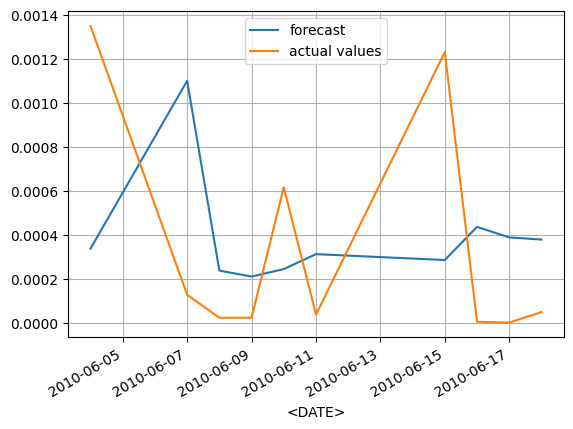

In [189]:
fvm.hist_output.plot(label='forecast')
(test_small ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

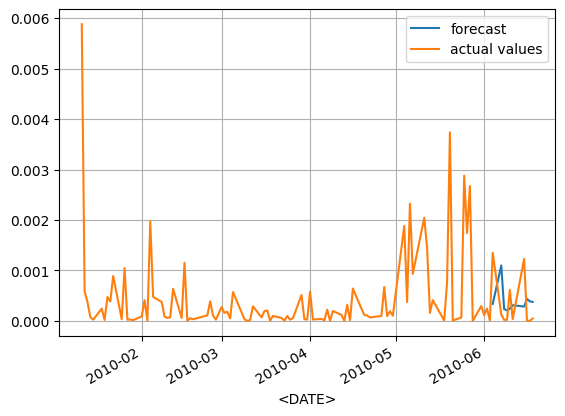

In [190]:
fvm.hist_output.plot(label='forecast')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

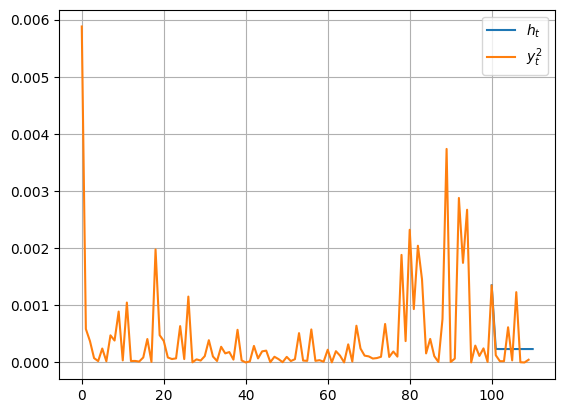

In [191]:
_h_w_nans = np.concatenate([[np.nan for _ in range(input_cut.shape[0] - n_points_fitting)], fvm.h])

plt.plot(_h_w_nans, label='$h_t$')
plt.plot(input_cut.values ** 2, label='$y_t^2$')

plt.legend()
plt.grid()
plt.show()

In [192]:
input_cut[-n_points_fitting:] ** 2

<DATE>
2010-06-04    1.350090e-03
2010-06-07    1.269412e-04
2010-06-08    2.234052e-05
2010-06-09    2.234052e-05
2010-06-10    6.160721e-04
2010-06-11    3.620283e-05
2010-06-15    1.231044e-03
2010-06-16    4.207162e-06
2010-06-17    3.436548e-08
2010-06-18    4.809967e-05
Name: log return, dtype: float64

In [193]:
fvm._h_hist

[array([0.00588077, 0.0011588 , 0.00041786, 0.00038764, 0.00034628,
        0.00033894, 0.00036957, 0.0003385 , 0.00040171, 0.00038909,
        0.00045964, 0.00034078, 0.00048159, 0.00033923, 0.00033936,
        0.00033781, 0.00034774, 0.00039276, 0.00033704, 0.00061096,
        0.00040231, 0.00038815, 0.0003478 , 0.00034398, 0.0003456 ,
        0.00042417, 0.00034395, 0.00049613, 0.0003362 , 0.00034318,
        0.00034025, 0.00035096, 0.0003899 , 0.00035022, 0.00033923,
        0.00037387, 0.00035778, 0.000361  , 0.00034256, 0.00041517,
        0.00034068, 0.00033568, 0.00033829, 0.0003759 , 0.00034551,
        0.00036267, 0.00036445, 0.00033633, 0.00034952, 0.0003438 ,
        0.00033628, 0.00034922, 0.00033905, 0.00034358, 0.00040706,
        0.00034028, 0.00033955, 0.00041605, 0.00033958, 0.00034121,
        0.00033745, 0.00036667, 0.00033585, 0.00036311, 0.00035232,
        0.00033574, 0.00037975, 0.00033785, 0.00042507, 0.00036961,
        0.00035225, 0.00035047, 0.00034516, 0.00

In [194]:
fvm._hist_output

[0.00033694600875488456954,
 0.0011004549864054243218,
 0.00023681480139623730619,
 0.00020968145228482238267,
 0.00024367365847699161347,
 0.00031168399695006843088,
 0.00028490614237498610404,
 0.00043575638661715342012,
 0.0003878153129177644371,
 0.00037803701321455920873,
 0.00023523096397404744733]

In [195]:
_p = fvm._parameters_hist[-1]
_p

{'alpha_0': array([0.00390298, 0.15537134, 0.00679794, 0.00019011]),
 'alpha': array([[9.06445381e-04, 1.21291158e-03, 1.16018158e-12, 1.16018156e-12]]),
 'beta': array([[4.23595816e-02, 1.20468585e-02, 1.18096504e-11, 1.34607623e-03]])}

In [196]:
calc_cond_var_fuzzy(_p['alpha_0'], _p['alpha'], _p['beta'],
                    input_cut[-n_points_fitting:] ** 2, [input_cut[-n_points_fitting:][0]],
                    fvm._membership_degrees_hist[-1])

array([-0.03674357,  0.00018579,  0.00023516,  0.00023523,  0.00023523,
        0.00023523,  0.00023523,  0.00023523,  0.00023523,  0.00023523,
        0.00023523], dtype=float128)

In [197]:
fvm._membership_degrees_hist[-1]

array([0.        , 0.        , 0.00678065, 0.99321935], dtype=float128)

## Errors

In [198]:
mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

0.0007564510760394400837

In [199]:
mean_squared_error(fvm.hist_output ** .5, test_small, squared=False)

0.027503655685007403825

In [200]:
mean_absolute_percentage_error(fvm.hist_output ** .5, test_small)

1.2082586674095231939

## RSS plots

In [151]:
ranges = {}

_step = .05
ranges['alpha_0'] = np.arange(0, 1 + _step, _step)

_step = .05
ranges['alpha'] = np.arange(0, 1 + _step, _step)

_step = .05
ranges['beta'] = np.arange(0, 1 + _step, _step)

In [152]:
%%time

rss = {'alpha_0': [], 'alpha': [], 'beta': []}

for _param_1cl in ranges['alpha_0']:
    _alpha_0 = np.concatenate([fvm.alpha_0[:-1], [_param_1cl]])
    _params = pack_1d_parameters(_alpha_0, fvm.alpha, fvm.beta)
    rss['alpha_0'].append((fvm._calc_residuals(_params) ** 2).sum())
    
for _param_1cl in ranges['alpha']:
    _alpha = np.concatenate([fvm.alpha[:, :-1], [[_param_1cl]]], axis=1)
    _params = pack_1d_parameters(fvm.alpha_0, _alpha, fvm.beta)
    rss['alpha'].append((fvm._calc_residuals(_params) ** 2).sum())
    
for _param_1cl in ranges['beta']:
    _beta = np.concatenate([fvm.beta[:, :-1], [[_param_1cl]]], axis=1)
    _params = pack_1d_parameters(fvm.alpha_0, fvm.alpha, _beta)
    rss['beta'].append((fvm._calc_residuals(_params) ** 2).sum())

CPU times: user 1.23 s, sys: 52.2 ms, total: 1.29 s
Wall time: 1.42 s


In [153]:
%%time

rss = {'alpha_0': {i: [] for i in range(n_clusters)},
       'alpha': {i: [] for i in range(n_clusters)},
       'beta': {i: [] for i in range(n_clusters)}}

for i in range(n_clusters):
    for _param_1cl in ranges['alpha_0']:
        _alpha_0 = np.concatenate([fvm.alpha_0[:i], [_param_1cl], fvm.alpha_0[i + 1:]])
        
        _params = pack_1d_parameters(_alpha_0, fvm.alpha, fvm.beta)
        rss['alpha_0'][i].append((fvm._calc_residuals(_params) ** 2).sum())

_par_name = 'alpha'
for i in range(n_clusters):
    for _param_1cl in ranges[_par_name]:
        _alpha = fvm.alpha.copy()
        _alpha[0, i] = _param_1cl
        
        _params = pack_1d_parameters(fvm.alpha_0, _alpha, fvm.beta)
        rss[_par_name][i].append((fvm._calc_residuals(_params) ** 2).sum())
       
_par_name = 'beta'
for i in range(n_clusters):
    for _param_1cl in ranges[_par_name]:
        _beta = fvm.alpha.copy()
        _beta[0, i] = _param_1cl
        
        _params = pack_1d_parameters(fvm.alpha_0, fvm.alpha, _beta)
        rss[_par_name][i].append((fvm._calc_residuals(_params) ** 2).sum())

CPU times: user 5.62 s, sys: 262 ms, total: 5.88 s
Wall time: 6.36 s


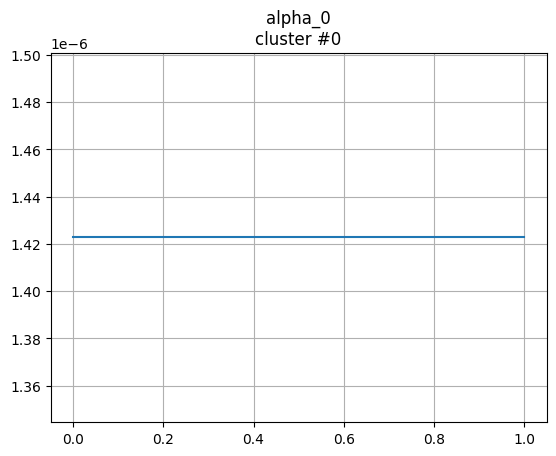

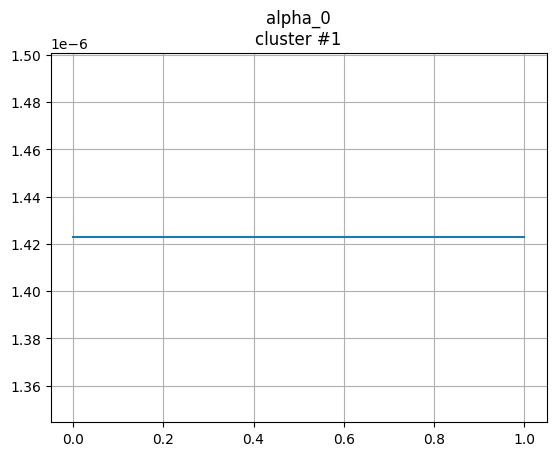

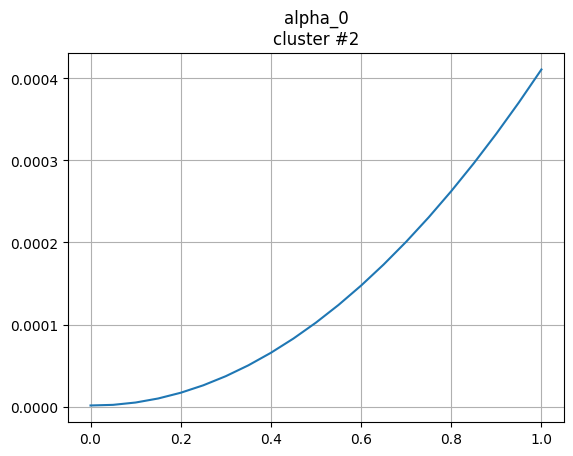

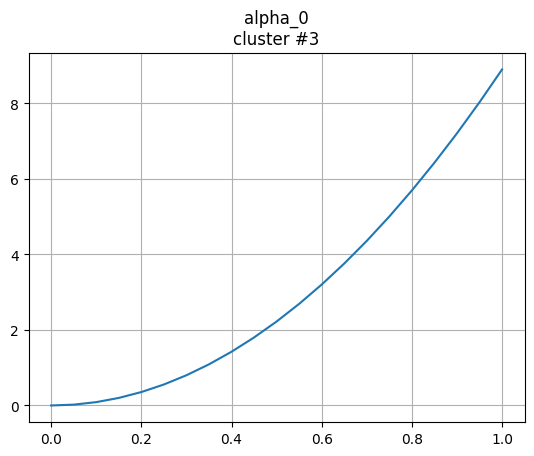

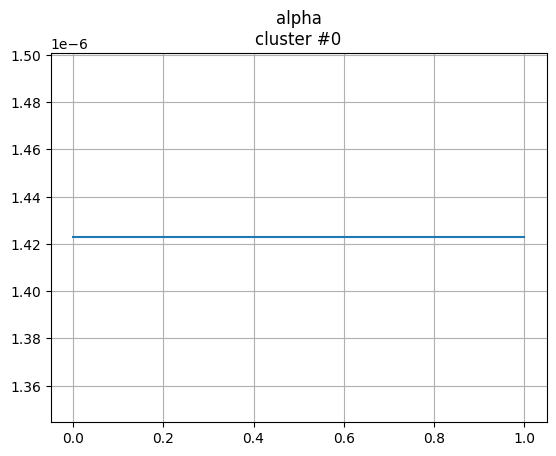

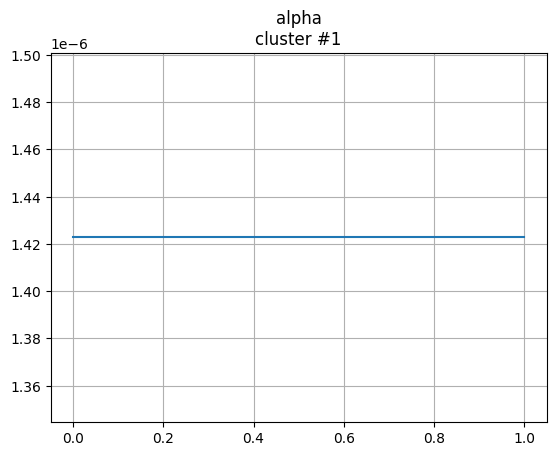

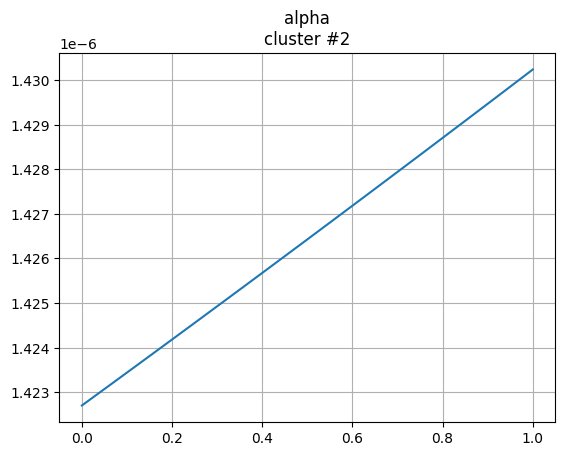

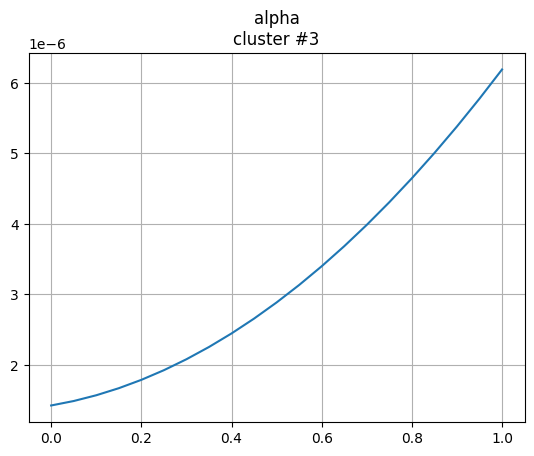

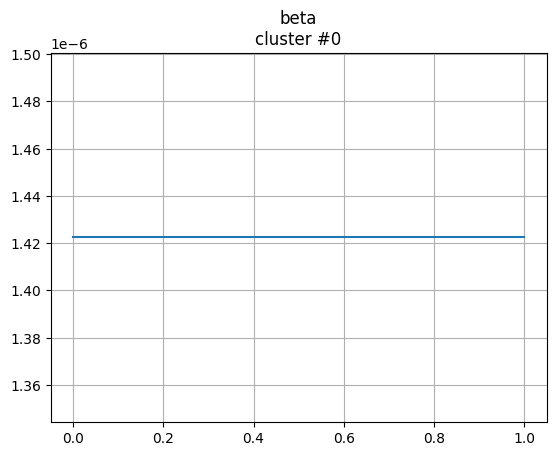

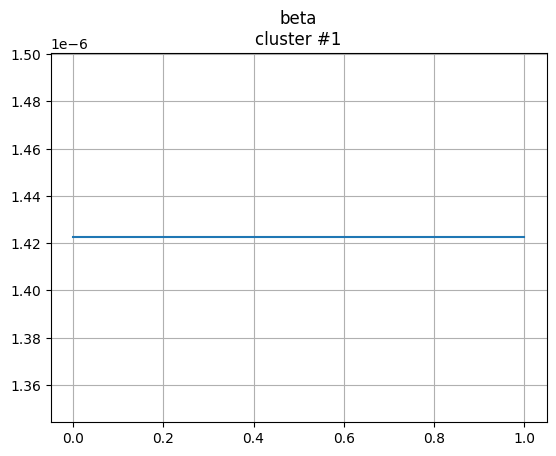

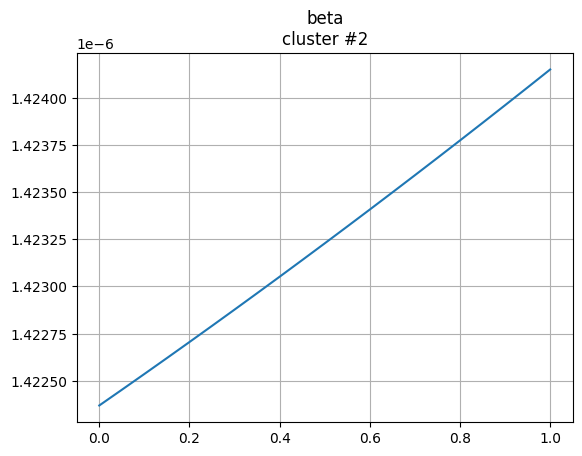

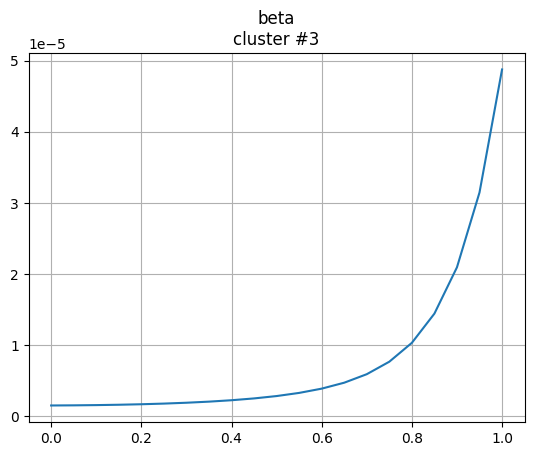

In [154]:
for _param, _rss_cl in rss.items():
    for _cl, _rss in _rss_cl.items():
        plt.plot(ranges[_param], _rss)

        plt.grid()
        plt.title(_param + '\n' + f'cluster #{_cl}')
        plt.show()

# Model w/o seasoning

In [ ]:
lower_bounds_2 = [0] * (1 + p + q) * n_clusters_2
upper_bounds_2 = [+np.inf] * n_clusters_2 + [1] * (p + q) * n_clusters_2
bounds_2 = (lower_bounds_2, upper_bounds_2)

In [ ]:
alpha_0_ini_2 = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters_2)])
alpha_ini_2 = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters_2)])
beta_ini_2 = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters_2)])

In [ ]:
parameters_ini_2 = {'alpha_0': alpha_0_ini_2, 'alpha': alpha_ini_2, 'beta': beta_ini_2}

In [ ]:
local_method_parameters_2 = local_method_parameters.copy()
local_method_parameters_2['bounds'] = bounds_2
local_method_parameters_2['parameters_ini'] = parameters_ini_2

In [ ]:
fvm_vanilla = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods[1],
                           clusterization_parameters=clusterization_parameters[1],
                           local_method=local_method,
                           local_method_parameters=local_method_parameters_2,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[1],
                           data_to_cluster=data_to_cluster[1],
                           cluster_sets_conjunction=cluster_sets_conjunction)

## `fit`

In [ ]:
%%time

fvm_vanilla.cluster()

In [ ]:
%%time

fvm_vanilla.fit()

In [ ]:
n_last_points_to_use_for_clustering

In [ ]:
fvm_vanilla.alpha_0

In [ ]:
fvm_vanilla.alpha

In [ ]:
fvm_vanilla.beta

In [ ]:
garch_fitted.params

In [ ]:
fvm_vanilla._parameters_hist

In [ ]:
fvm_vanilla.membership_degrees_current

In [ ]:
fvm_vanilla.clusters_parameters_current

In [ ]:
data_to_cluster

In [ ]:
fvm_vanilla._membership_degrees_hist

In [ ]:
fvm_vanilla.train_data

## `forecast`

In [ ]:
fvm_vanilla.forecast()

In [ ]:
fvm_vanilla.current_output

In [ ]:
fvm_vanilla._hist_output

In [ ]:
plt.plot(fvm_vanilla.h, label='sqrt(h_t)')
plt.plot(train.values ** 2, label='y_t')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvm_vanilla.h

## `feed_daily_data`

In [ ]:
# n_test_small = 10
# test_small = test.iloc[:n_test_small].copy()
# input_cut = pd.concat([train, test_small]).copy()

# data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
# data_to_cluster_test_2 = 'train'
# data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]

In [ ]:
%%time

fvm_vanilla.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test_2)

In [ ]:
fvm_vanilla.data_to_cluster

In [ ]:
len(fvm_vanilla._hist_output)

In [ ]:
fvm_vanilla.h

In [ ]:
_.shape

In [ ]:
fvm_vanilla.data_to_cluster[-10:]

In [ ]:
fvm_vanilla.membership_degrees_hist

In [ ]:
fvm_vanilla.hist_output

In [ ]:
test

In [ ]:
fvm_vanilla.membership_degrees_current

In [ ]:
fvm_vanilla.clusterization_parameters

In [ ]:
fvm_vanilla._parameters_hist

### Plots

In [ ]:
plt.plot((np.array(fvm_vanilla._hist_output) ** .5), label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [ ]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=True)

In [ ]:
_ / mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

In [ ]:
(_ - 1) * 100

In [ ]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=False)

In [ ]:
mean_absolute_percentage_error(fvm_vanilla.hist_output ** .5, test_small)

## Diff w/ seasonal model

In [ ]:
np.array(fvm._hist_output) - np.array(fvm_vanilla._hist_output)

In [ ]:
_.mean()

## Same data fed to GARCH(1, 1)

### No retraining

In [ ]:
model = arch_model(train,
                   mean=local_method_parameters['mean'],
                   vol='GARCH', p=local_method_parameters['p'],
                   q=local_method_parameters['q'],
                   dist=local_method_parameters['dist'])

In [ ]:
model.volatility

In [ ]:
fitted = model.fit()

In [ ]:
fitted.summary

In [ ]:
fitted.params

In [ ]:
fvm.alpha_0

In [ ]:
fvm.alpha

In [ ]:
fvm.beta

In [ ]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [ ]:
forecast_variance = forecast.variance.iloc[0]

In [ ]:
forecast_variance

In [ ]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [ ]:
mean_squared_error(simple_garch_forecasts, test_small ** 2, squared=True)

### With retraining

In [ ]:
def calc_vanilla_garch_wr_mse(info, data, garch_mean, garch_vol, garch_dist):
    train_size = info.loc['Train size']
    test_size = info.loc['Test size']
    p = info.loc['p']
    q = info.loc['q']
    
    train = data[info.loc['Start date']:].iloc[:train_size]
    test = data[info.loc['Start date']:].iloc[train_size:(train_size + test_size)]
    
    forecast = calculate_retraining_garch_forecasts(train, test,
                                                    mean=garch_mean,
                                                    vol=garch_vol,
                                                    p=p,
                                                    q=q,
                                                    dist=garch_dist)
    
    mse = mean_squared_error(forecast, test ** 2, squared=True)
    
    return mse

# Bollocks

In [ ]:
from multiprocessing import Pool

In [ ]:
def f(length):
    arr = []
    for i in range(int(length)):
        arr.append(i + 1)
    return arr

In [ ]:
%%time

arr = f(1e5)

# Testing clustering

## 1d

In [ ]:
x = [data_to_cluster[0], data_to_cluster[0]].copy()
methods = clusterization_methods
parameters = clusterization_parameters

In [ ]:
clustering_results = []
for i, (_x, _method) in enumerate(zip(x, methods)):
    _clustering_result = cluster_data_1d(_x,
                                         method=_method,
                                         parameters=parameters[i] if parameters is not None else None,
                                         n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[i]
                                         if n_last_points_to_use_for_clustering is not None else None)
    clustering_results.append(_clustering_result)

In [ ]:
[
    cluster_data_1d(_x,
                    method=_method,
                    parameters=_parameters,
                    n_last_points_to_use_for_clustering=_n_last_points_to_use_for_clustering)
    for _x, _method, _parameters, _n_last_points_to_use_for_clustering in
    zip(x, methods, parameters, n_last_points_to_use_for_clustering)
]

## multidim

In [ ]:
n_cluster_sets = 2

In [ ]:
dtc = \
    pd.concat([pd.concat([data_to_cluster[0], data_to_cluster_test[0]]),
               pd.concat([train, test])], axis='columns').copy()

In [ ]:
help(dtc.rolling)

In [ ]:
dtc.iloc[train.shape[0] - test.shape[0] - 1:].expanding(min_periods=1).apply(lambda _row: _row.shape[0])

In [ ]:
dtc.iloc[train.shape[0] - test.shape[0] - 1:].rolling(10, min_periods=1).apply(lambda _row: _row.shape[0])

In [ ]:
dtc

In [ ]:
cluster_data(data_to_cluster,
             methods=clusterization_methods,
             parameters=clusterization_parameters,
             n_last_points_to_use_for_clustering=
             n_last_points_to_use_for_clustering,
             conjunction=cluster_sets_conjunction,
             n_sets=n_cluster_sets,
             normalize=normalize)

# Testing `expanding` w/ `numba`

In [ ]:
def f(df: pd.DataFrame) -> pd.Series:
    return df.iloc[:, 0] + df.iloc[:, 1]

In [ ]:
def f2(df: np.array) -> np.array:
    return df[:, 0] + df[:, 1]

In [ ]:
def f3(df: np.array) -> np.array:
    return (df[:, 0] + df[:, 1], df[:, 0] - df[:, 1])

In [ ]:
def f4(df: np.array) -> tuple:
    return (df[:, 0].mean(), df[:, 1].mean())

In [ ]:
f(dtc)

In [ ]:
f2(dtc.values)

In [ ]:
f3(dtc.values)

In [ ]:
f4(dtc.values)

In [ ]:
dtc.expanding(method='table').apply(f4, engine='numba', raw=True)

In [ ]:
np.vstack([np.array([1, 2, 3]), np.array([4, 5, 6])]).T